In [1]:
import PIL
from tensorflow.keras import layers
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Rescaling, Dropout
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pathlib

In [2]:
data_dir = pathlib.Path('flower_photos')

batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [3]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99153596


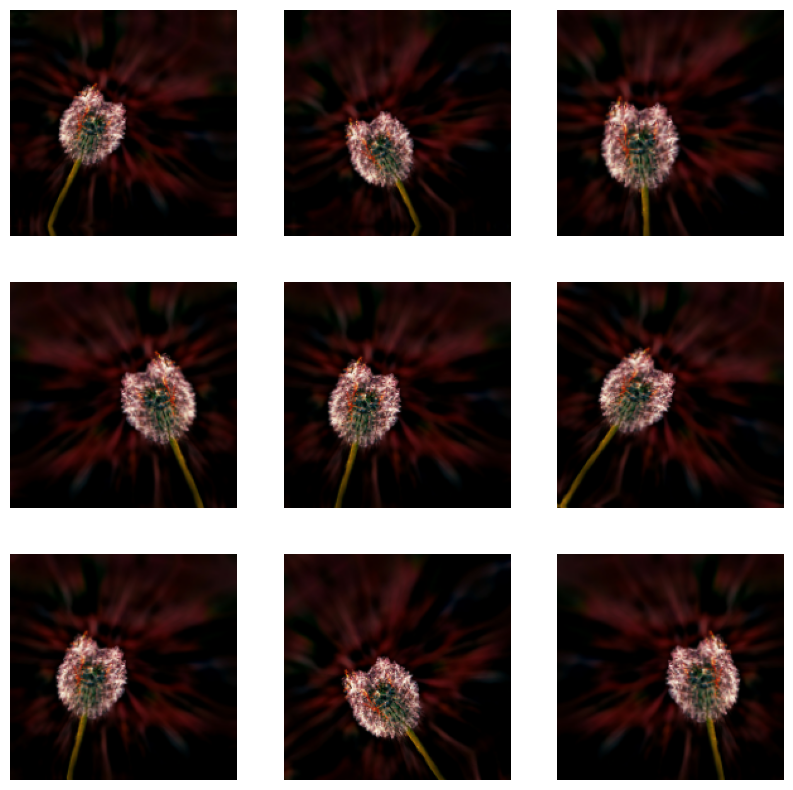

In [25]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [26]:
num = len(class_names)
inputs = Input(shape=(img_height,img_width,3))
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])
x = data_augmentation(inputs)
x = Rescaling(1./255)(x)
x = Conv2D(16,3,padding='same', activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32,3,padding='same', activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64,3,padding='same', activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(num)(x)

In [27]:
model = Model(inputs, outputs)

In [28]:
model.compile(optimizer='adam', 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_4 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 39s 369ms/step - accuracy: 0.3474 - loss: 1.5563 - val_accuracy: 0.5027 - val_loss: 1.2457
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 354ms/step - accuracy: 0.5452 - loss: 1.0698 - val_accuracy: 0.6417 - val_loss: 0.9456
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 356ms/step - accuracy: 0.6480 - loss: 0.9097 - val_accuracy: 0.6049 - val_loss: 0.9977
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 355ms/step - accuracy: 0.6567 - loss: 0.8685 - val_accuracy: 0.6785 - val_loss: 0.8390
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 355ms/step - accuracy: 0.7103 - loss: 0.7709 - val_accuracy: 0.6485 - val_loss: 0.9576
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 356ms/step - accuracy: 0.7088 - loss: 0.7364 - val_accuracy: 0.6798 - val_loss: 0.8111
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 356ms/step - accuracy: 0.7324 - loss: 0.6983 - val_accuracy: 0.6975 - val_loss: 0.7741
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 360ms/step - accuracy: 0.7362 - loss: 0.6873 - val_accu

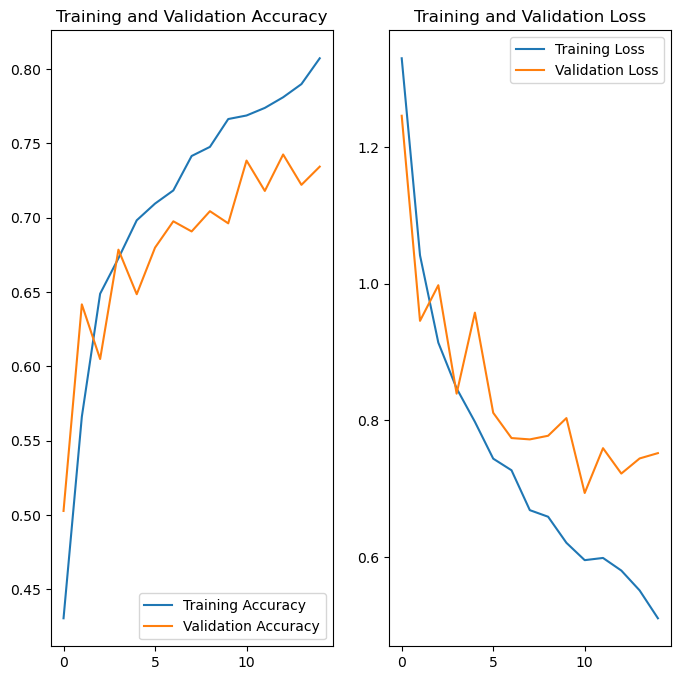

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [59]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

117948/117948 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
This image most likely belongs to sunflowers with a 97.43 percent confidence.
